In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 741
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HS78Q8CD_04_37_01
NN-MODEL FILENAME:  ./models/HS78Q8CD_04_37_01_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 4
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  4


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 47125.36 MiB, increment: 43077.32 MiB
Quantization TIME:  0.39 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15670
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 62
TOTAL SERIAL TIMESTEPS:   15670
TOTAL PARALLEL TIMESTEPS: 62


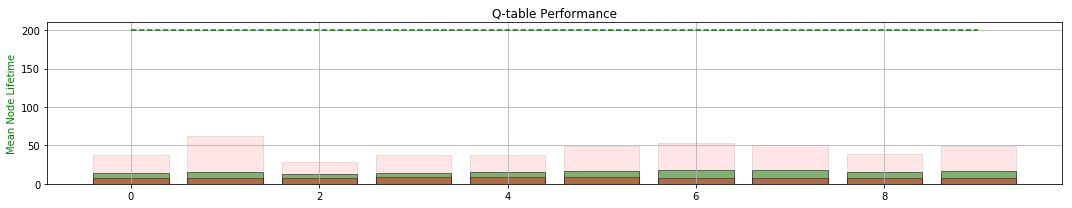

MEMORY COUNTER:  15670
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 584.116	LOSS : 563.433	LOSS : 551.868	LOSS : 526.845	LOSS : 512.225	LOSS : 509.150	LOSS : 536.197	LOSS : 516.482	LOSS : 509.633	LOSS : 503.750	LOSS : 529.685	LOSS : 501.053	LOSS : 488.883	LOSS : 508.698	LOSS : 494.136	LOSS : 471.630	LOSS : 469.893	LOSS : 486.981	LOSS : 469.517	LOSS : 481.414	
Validating... MEAN TIME:  93.745
LOSS : 476.836	LOSS : 463.905	LOSS : 460.999	LOSS : 453.064	LOSS : 452.664	LOSS : 451.684	LOSS : 451.912	LOSS : 454.035	LOSS : 449.800	LOSS : 449.531	LOSS : 456.482	LOSS : 444.323	LOSS : 442.200	LOSS : 440.306	LOSS : 447.432	LOSS : 443.039	LOSS : 433.083	LOSS : 453.268	LOSS : 469.372	LOSS : 461.295	
Validating... MEAN TIME:  122.745
LOSS : 460.955	LOSS : 452.574	LOSS : 443.161	LOSS : 478.216	LOSS : 459.363	LOSS : 447.876	LOSS : 458.490	LOSS : 463.792	LOSS : 464.745	LOSS : 446.083	LOSS : 490.690	LOSS : 469.537	LOSS : 466.842	LOSS : 475.043	LOSS : 483.022	LOSS : 462.024	LOSS : 49

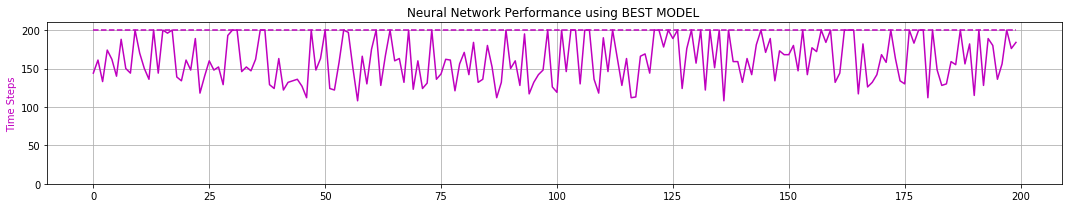

peak memory: 48397.94 MiB, increment: 43532.36 MiB
0 -max- [ 0.176  1.522  0.209  2.636  0.275]
0 -min- [-0.292 -1.779 -0.203 -2.462  0.225]

1 -max- [ 0.223  2.362  0.209  2.769  0.325]
1 -min- [-0.460 -1.782 -0.207 -2.987  0.275]

2 -max- [ 0.194  1.971  0.209  2.674  0.374]
2 -min- [-0.224 -1.724 -0.209 -2.967  0.326]

3 -max- [ 0.205  1.796  0.209  2.690  0.425]
3 -min- [-0.339 -2.437 -0.206 -2.723  0.375]

4 -max- [ 0.211  1.776  0.209  2.386  0.474]
4 -min- [-0.231 -1.890 -0.208 -2.729  0.425]

5 -max- [ 0.326  2.262  0.209  2.173  0.525]
5 -min- [-0.246 -1.415 -0.209 -2.822  0.475]

6 -max- [ 0.318  2.270  0.209  2.118  0.575]
6 -min- [-0.195 -1.415 -0.209 -2.787  0.526]

7 -max- [ 0.345  2.671  0.209  2.751  0.624]
7 -min- [-0.252 -1.711 -0.208 -3.127  0.576]

8 -max- [ 0.209  2.128  0.208  2.002  0.675]
8 -min- [-0.217 -1.353 -0.208 -3.029  0.626]

9 -max- [ 0.656  2.503  0.209  1.650  0.724]
9 -min- [-0.105 -0.973 -0.209 -2.782  0.676]

Quantization TIME:  0.39 minutes


ITER

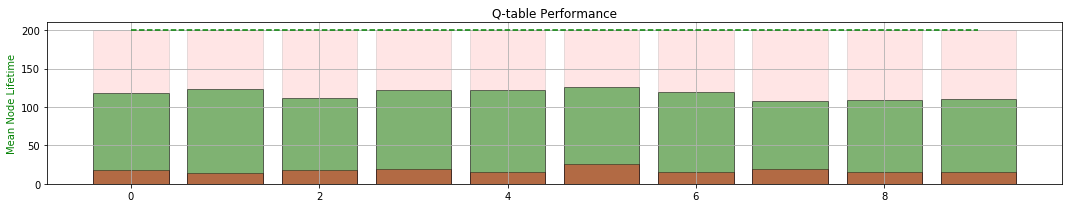

MEMORY COUNTER:  132816
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 284.845	LOSS : 271.626	LOSS : 242.196	LOSS : 243.910	LOSS : 231.978	LOSS : 232.052	LOSS : 214.343	LOSS : 210.356	LOSS : 214.592	LOSS : 210.179	LOSS : 208.234	LOSS : 184.609	LOSS : 197.106	LOSS : 190.194	LOSS : 191.352	LOSS : 197.356	LOSS : 182.453	LOSS : 167.143	LOSS : 180.519	LOSS : 174.670	
Validating... MEAN TIME:  170.915
LOSS : 168.678	LOSS : 167.540	LOSS : 170.604	LOSS : 167.720	LOSS : 165.298	LOSS : 153.014	LOSS : 161.560	LOSS : 165.912	LOSS : 168.817	LOSS : 144.741	LOSS : 170.647	LOSS : 159.532	LOSS : 157.049	LOSS : 162.219	LOSS : 153.485	LOSS : 159.187	LOSS : 143.874	LOSS : 163.627	LOSS : 159.000	LOSS : 156.245	
Validating... MEAN TIME:  192.835
LOSS : 157.014	LOSS : 150.362	LOSS : 158.967	LOSS : 151.777	LOSS : 157.412	LOSS : 162.670	LOSS : 149.902	LOSS : 153.304	LOSS : 153.656	LOSS : 160.226	LOSS : 159.538	LOSS : 164.835	LOSS : 171.662	LOSS : 153.146	LOSS : 161.392	LOSS : 144.541	LOSS : 

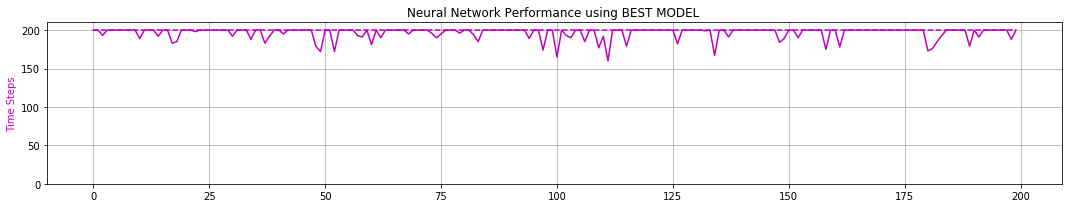

peak memory: 49166.16 MiB, increment: 43478.09 MiB
0 -max- [ 1.131  1.883  0.209  2.208  0.275]
0 -min- [-1.159 -1.874 -0.209 -2.024  0.225]

1 -max- [ 1.076  1.911  0.209  2.329  0.324]
1 -min- [-1.087 -2.102 -0.209 -2.088  0.277]

2 -max- [ 1.254  2.410  0.209  2.258  0.375]
2 -min- [-1.143 -1.937 -0.209 -2.466  0.325]

3 -max- [ 1.121  1.896  0.209  2.054  0.425]
3 -min- [-1.421 -2.206 -0.209 -2.069  0.375]

4 -max- [ 1.276  1.904  0.207  2.167  0.475]
4 -min- [-1.485 -2.252 -0.209 -3.039  0.425]

5 -max- [ 1.514  2.221  0.209  2.404  0.524]
5 -min- [-1.367 -2.131 -0.209 -2.592  0.476]

6 -max- [ 1.180  2.120  0.209  2.342  0.575]
6 -min- [-1.295 -1.857 -0.209 -2.807  0.527]

7 -max- [ 1.136  1.896  0.209  2.245  0.624]
7 -min- [-1.417 -2.204 -0.209 -2.567  0.576]

8 -max- [ 1.236  2.051  0.209  2.116  0.675]
8 -min- [-1.149 -2.071 -0.209 -2.312  0.625]

9 -max- [ 1.093  1.691  0.209  2.087  0.725]
9 -min- [-1.332 -2.038 -0.209 -2.341  0.675]

Quantization TIME:  0.39 minutes


ITER

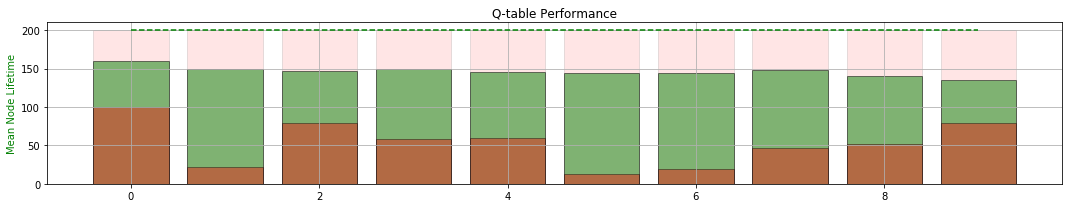

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 84.412	LOSS : 72.067	LOSS : 75.958	LOSS : 75.091	LOSS : 74.467	LOSS : 75.618	LOSS : 69.183	LOSS : 78.776	LOSS : 71.472	LOSS : 71.055	LOSS : 64.464	LOSS : 67.622	LOSS : 65.433	LOSS : 66.833	LOSS : 66.166	LOSS : 60.577	LOSS : 62.745	LOSS : 72.181	LOSS : 66.294	LOSS : 62.589	
Validating... MEAN TIME:  175.065
LOSS : 66.702	LOSS : 65.161	LOSS : 65.036	LOSS : 70.579	LOSS : 74.537	LOSS : 70.495	LOSS : 72.747	LOSS : 63.552	LOSS : 69.617	LOSS : 64.972	LOSS : 68.848	LOSS : 71.358	LOSS : 68.083	LOSS : 67.104	LOSS : 57.313	LOSS : 64.697	LOSS : 59.506	LOSS : 70.326	LOSS : 64.657	LOSS : 61.146	
Validating... MEAN TIME:  173.99
LOSS : 64.877	LOSS : 68.840	LOSS : 66.673	LOSS : 65.319	LOSS : 63.525	LOSS : 65.951	LOSS : 64.768	LOSS : 65.498	LOSS : 65.352	LOSS : 66.406	LOSS : 74.248	LOSS : 60.113	LOSS : 74.688	LOSS : 63.706	LOSS : 63.678	LOSS : 60.091	LOSS : 63.035	LOSS : 64.053	LOSS : 55.772	LOSS : 65.676	
Validat

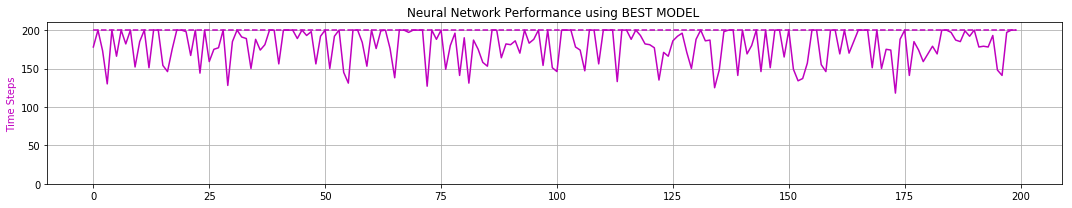

peak memory: 48825.98 MiB, increment: 43088.98 MiB
0 -max- [ 1.258  1.322  0.207  1.885  0.275]
0 -min- [-2.336 -2.572 -0.209 -1.773  0.225]

1 -max- [ 1.429  1.901  0.208  1.988  0.324]
1 -min- [-2.291 -2.549 -0.209 -1.947  0.275]

2 -max- [ 0.381  1.298  0.126  1.638  0.375]
2 -min- [-2.238 -2.514 -0.209 -1.691  0.325]

3 -max- [ 1.098  1.491  0.167  1.642  0.424]
3 -min- [-2.092 -2.424 -0.209 -1.858  0.375]

4 -max- [ 1.120  1.728  0.181  1.917  0.474]
4 -min- [-2.182 -2.558 -0.209 -1.899  0.425]

5 -max- [ 0.987  1.394  0.173  1.846  0.524]
5 -min- [-2.153 -2.401 -0.209 -1.768  0.475]

6 -max- [ 0.799  1.223  0.197  1.615  0.575]
6 -min- [-2.031 -2.386 -0.209 -1.890  0.525]

7 -max- [ 0.335  1.313  0.171  1.738  0.625]
7 -min- [-2.213 -2.576 -0.209 -1.852  0.576]

8 -max- [ 1.103  1.350  0.161  1.861  0.674]
8 -min- [-2.272 -2.602 -0.209 -1.917  0.625]

9 -max- [ 0.161  1.341  0.176  1.970  0.725]
9 -min- [-1.983 -2.407 -0.209 -1.989  0.675]

Quantization TIME:  0.39 minutes


ITER

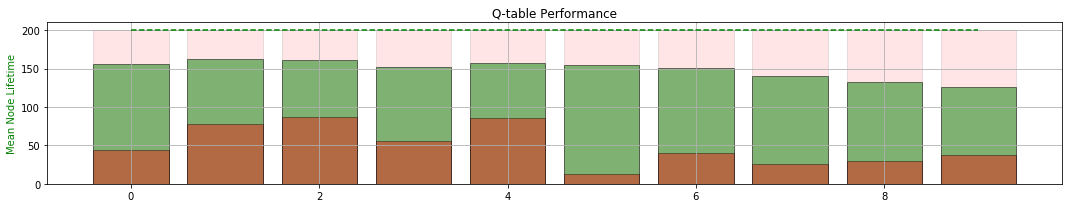

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 65.039	LOSS : 74.433	LOSS : 66.644	LOSS : 72.432	LOSS : 60.632	LOSS : 57.141	LOSS : 64.853	LOSS : 62.852	LOSS : 63.932	LOSS : 68.135	LOSS : 65.143	LOSS : 65.329	LOSS : 67.677	LOSS : 60.132	LOSS : 68.211	LOSS : 64.464	LOSS : 64.851	LOSS : 70.308	LOSS : 64.200	LOSS : 65.492	
Validating... MEAN TIME:  137.445
LOSS : 68.755	LOSS : 63.915	LOSS : 72.216	LOSS : 61.194	LOSS : 67.877	LOSS : 68.706	LOSS : 64.791	LOSS : 73.948	LOSS : 60.985	LOSS : 69.873	LOSS : 65.524	LOSS : 60.516	LOSS : 73.676	LOSS : 69.405	LOSS : 68.549	LOSS : 64.837	LOSS : 59.928	LOSS : 61.126	LOSS : 63.393	LOSS : 59.219	
Validating... MEAN TIME:  146.145
LOSS : 63.432	LOSS : 73.513	LOSS : 65.835	LOSS : 72.268	LOSS : 69.795	LOSS : 64.457	LOSS : 73.701	LOSS : 53.623	LOSS : 61.738	LOSS : 67.439	LOSS : 69.345	LOSS : 66.614	LOSS : 65.455	LOSS : 69.761	LOSS : 68.660	LOSS : 66.395	LOSS : 59.618	LOSS : 67.678	LOSS : 63.623	LOSS : 69.639	
Valida

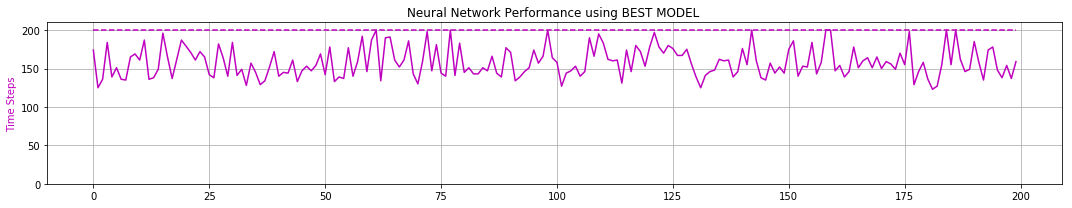

peak memory: 49479.99 MiB, increment: 43720.57 MiB
0 -max- [ 2.400  2.607  0.208  2.145  0.275]
0 -min- [-2.400 -2.785 -0.209 -2.075  0.225]

1 -max- [ 2.199  2.340  0.201  1.950  0.324]
1 -min- [-2.398 -2.783 -0.209 -1.930  0.276]

2 -max- [ 2.312  2.426  0.194  1.953  0.374]
2 -min- [-2.400 -2.780 -0.209 -1.969  0.325]

3 -max- [ 2.375  2.593  0.200  1.947  0.425]
3 -min- [-2.396 -2.888 -0.209 -2.237  0.375]

4 -max- [ 2.391  2.732  0.201  1.899  0.475]
4 -min- [-2.398 -2.783 -0.209 -2.212  0.425]

5 -max- [ 2.385  2.785  0.208  1.966  0.524]
5 -min- [-2.397 -2.783 -0.209 -2.215  0.475]

6 -max- [ 2.259  3.224  0.209  2.073  0.573]
6 -min- [-2.399 -2.754 -0.209 -2.253  0.526]

7 -max- [ 2.155  2.422  0.209  2.265  0.625]
7 -min- [-2.353 -2.744 -0.209 -2.187  0.577]

8 -max- [ 2.251  2.415  0.209  1.946  0.675]
8 -min- [-2.203 -2.569 -0.209 -2.264  0.625]

9 -max- [ 1.482  2.109  0.206  2.165  0.725]
9 -min- [-2.309 -2.737 -0.209 -2.242  0.675]

Quantization TIME:  0.39 minutes


ITER

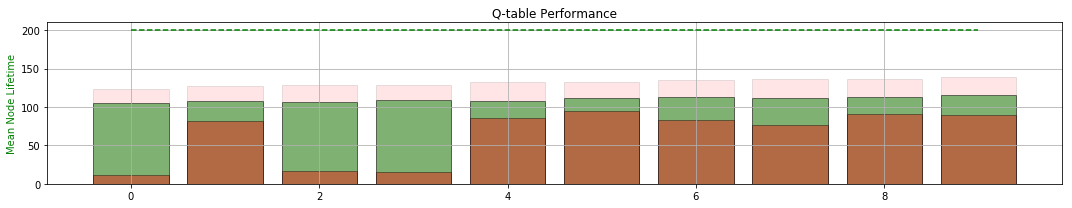

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 76.436	LOSS : 90.264	LOSS : 87.065	LOSS : 71.655	LOSS : 84.403	LOSS : 74.193	LOSS : 82.803	LOSS : 76.230	LOSS : 84.685	LOSS : 76.249	LOSS : 77.306	LOSS : 68.920	LOSS : 79.360	LOSS : 75.589	LOSS : 74.957	LOSS : 79.408	LOSS : 73.025	LOSS : 74.461	LOSS : 73.603	LOSS : 76.175	
Validating... MEAN TIME:  105.625
LOSS : 69.509	LOSS : 72.704	LOSS : 63.623	LOSS : 71.764	LOSS : 64.101	LOSS : 71.132	LOSS : 70.831	LOSS : 84.882	LOSS : 58.345	LOSS : 69.418	LOSS : 73.232	LOSS : 62.802	LOSS : 71.981	LOSS : 74.460	LOSS : 75.903	LOSS : 65.218	LOSS : 72.308	LOSS : 74.745	LOSS : 69.778	LOSS : 74.542	
Validating... MEAN TIME:  105.085
LOSS : 66.425	LOSS : 76.419	LOSS : 71.718	LOSS : 68.453	LOSS : 58.476	LOSS : 71.826	LOSS : 66.205	LOSS : 75.897	LOSS : 61.891	LOSS : 74.440	LOSS : 75.528	LOSS : 59.632	LOSS : 73.870	LOSS : 74.452	LOSS : 73.167	LOSS : 82.129	LOSS : 70.398	LOSS : 73.600	LOSS : 69.734	LOSS : 68.555	
Valida

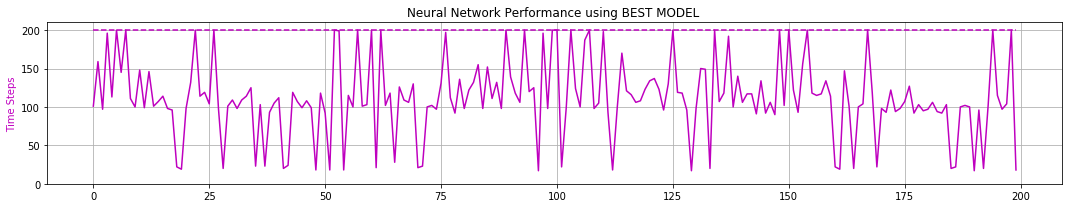

peak memory: 48871.83 MiB, increment: 43143.83 MiB
0 -max- [ 0.161  1.197  0.050  1.241  0.275]
0 -min- [-2.398 -2.942 -0.209 -1.652  0.228]

1 -max- [ 0.160  1.196  0.049  1.236  0.325]
1 -min- [-2.379 -2.946 -0.209 -1.654  0.275]

2 -max- [ 0.169  1.146  0.049  1.166  0.374]
2 -min- [-2.387 -2.921 -0.209 -1.657  0.327]

3 -max- [ 0.167  1.213  0.051  1.074  0.425]
3 -min- [-2.384 -2.915 -0.209 -1.655  0.375]

4 -max- [ 0.156  0.803  0.049  1.128  0.474]
4 -min- [-2.352 -2.762 -0.209 -1.165  0.425]

5 -max- [ 0.158  0.969  0.050  0.999  0.525]
5 -min- [-2.306 -2.742 -0.209 -1.365  0.476]

6 -max- [ 0.149  0.941  0.057  0.970  0.574]
6 -min- [-2.144 -2.610 -0.209 -1.315  0.526]

7 -max- [ 0.156  0.802  0.049  1.159  0.625]
7 -min- [-2.170 -2.602 -0.209 -1.237  0.575]

8 -max- [ 0.119  0.803  0.050  1.000  0.674]
8 -min- [-2.148 -2.567 -0.209 -1.210  0.626]

9 -max- [ 0.127  0.801  0.049  0.975  0.724]
9 -min- [-2.082 -2.406 -0.209 -1.196  0.676]

Quantization TIME:  0.39 minutes


ITER

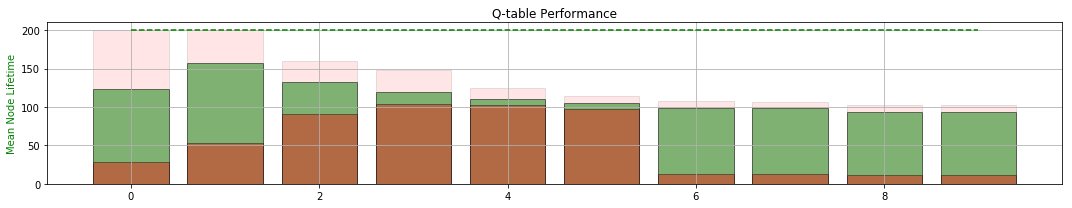

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 95.545	LOSS : 85.070	LOSS : 82.098	LOSS : 73.875	LOSS : 79.071	LOSS : 77.551	LOSS : 76.526	LOSS : 85.550	LOSS : 71.942	LOSS : 82.890	LOSS : 76.028	LOSS : 83.032	LOSS : 81.858	LOSS : 77.887	LOSS : 76.252	LOSS : 77.439	LOSS : 78.768	LOSS : 79.733	LOSS : 82.896	LOSS : 89.648	
Validating... MEAN TIME:  150.09
LOSS : 86.122	LOSS : 85.164	LOSS : 77.473	LOSS : 77.207	LOSS : 79.276	LOSS : 81.267	LOSS : 91.158	LOSS : 87.058	LOSS : 81.428	LOSS : 93.968	LOSS : 85.806	LOSS : 85.895	LOSS : 76.355	LOSS : 82.749	LOSS : 85.732	LOSS : 82.230	LOSS : 86.165	LOSS : 84.159	LOSS : 81.281	LOSS : 97.437	
Validating... MEAN TIME:  167.345
LOSS : 80.875	LOSS : 84.871	LOSS : 90.571	LOSS : 78.436	LOSS : 76.932	LOSS : 88.933	LOSS : 88.391	LOSS : 88.347	LOSS : 80.992	LOSS : 83.756	LOSS : 86.811	LOSS : 77.301	LOSS : 76.222	LOSS : 85.412	LOSS : 84.775	LOSS : 81.540	LOSS : 82.381	LOSS : 82.899	LOSS : 85.014	LOSS : 89.339	
Validat

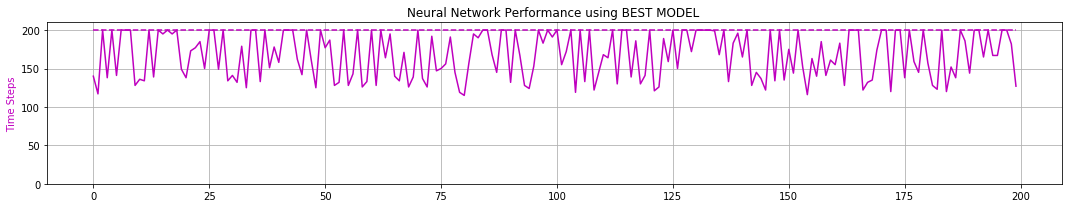

peak memory: 49327.62 MiB, increment: 43560.58 MiB
0 -max- [ 1.786  2.206  0.130  1.160  0.274]
0 -min- [-2.399 -2.966 -0.209 -1.171  0.225]

1 -max- [ 2.398  2.966  0.148  1.418  0.325]
1 -min- [-2.395 -2.896 -0.209 -1.373  0.275]

2 -max- [ 2.400  3.145  0.175  1.177  0.375]
2 -min- [-0.134 -0.790 -0.209 -1.416  0.326]

3 -max- [ 2.400  3.204  0.183  1.457  0.425]
3 -min- [-0.167 -0.931 -0.199 -1.505  0.376]

4 -max- [ 2.399  3.140  0.170  1.477  0.475]
4 -min- [-0.141 -0.975 -0.080 -1.341  0.425]

5 -max- [ 2.400  3.171  0.203  1.725  0.525]
5 -min- [-0.159 -1.153 -0.048 -1.332  0.476]

6 -max- [ 2.397  3.143  0.209  1.508  0.575]
6 -min- [-0.193 -1.023 -0.048 -1.262  0.525]

7 -max- [ 2.399  3.336  0.209  1.772  0.624]
7 -min- [-0.194 -1.182 -0.050 -1.375  0.575]

8 -max- [ 2.399  3.139  0.208  1.757  0.674]
8 -min- [-0.179 -1.211 -0.048 -1.177  0.625]

9 -max- [ 2.399  3.169  0.208  1.767  0.725]
9 -min- [-0.181 -1.216 -0.051 -1.070  0.678]

Quantization TIME:  0.39 minutes


ITER

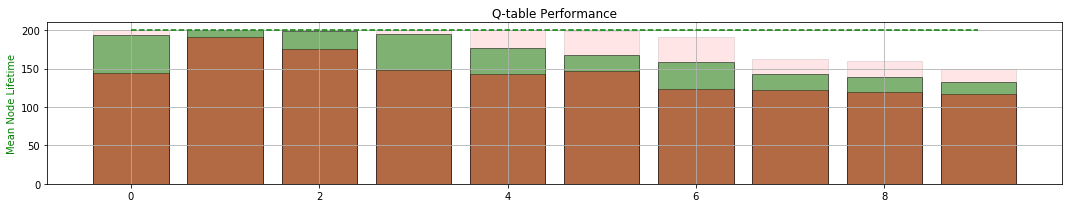

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 58.960	LOSS : 62.661	LOSS : 61.462	LOSS : 66.429	LOSS : 63.822	LOSS : 67.556	LOSS : 59.455	LOSS : 66.273	LOSS : 57.380	LOSS : 53.628	LOSS : 65.044	LOSS : 57.609	LOSS : 60.163	LOSS : 60.710	LOSS : 62.448	LOSS : 57.537	LOSS : 64.130	LOSS : 61.174	LOSS : 70.891	LOSS : 67.956	
Validating... MEAN TIME:  141.66
LOSS : 61.888	LOSS : 65.264	LOSS : 58.477	LOSS : 58.375	LOSS : 54.188	LOSS : 53.740	LOSS : 55.792	LOSS : 59.684	LOSS : 65.726	LOSS : 51.334	LOSS : 70.078	LOSS : 57.872	LOSS : 58.511	LOSS : 56.466	LOSS : 68.736	LOSS : 57.912	LOSS : 58.318	LOSS : 65.061	LOSS : 66.092	LOSS : 73.497	
Validating... MEAN TIME:  99.105
LOSS : 60.134	LOSS : 65.807	LOSS : 57.853	LOSS : 60.305	LOSS : 55.196	LOSS : 63.215	LOSS : 63.928	LOSS : 60.432	LOSS : 68.436	LOSS : 68.107	LOSS : 74.624	LOSS : 54.185	LOSS : 51.220	LOSS : 60.430	LOSS : 61.528	LOSS : 54.875	LOSS : 61.245	LOSS : 54.638	LOSS : 58.172	LOSS : 59.161	
Validati

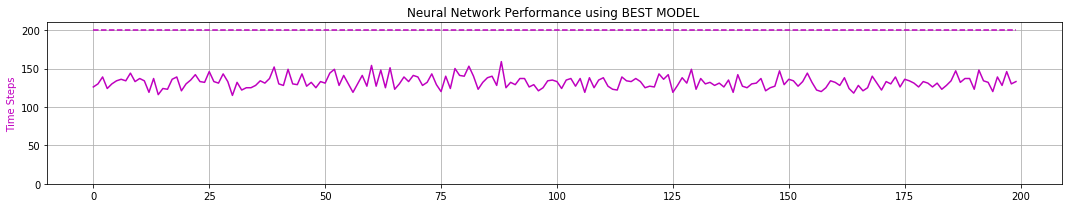

peak memory: 49201.98 MiB, increment: 43421.92 MiB
0 -max- [ 0.701  0.745  0.052  0.730  0.275]
0 -min- [-1.365 -1.486 -0.209 -0.991  0.226]

1 -max- [ 2.034  1.684  0.203  0.656  0.325]
1 -min- [-1.252 -1.237 -0.196 -0.731  0.277]

2 -max- [ 2.215  1.965  0.209  0.880  0.375]
2 -min- [-0.572 -0.592 -0.053 -0.706  0.325]

3 -max- [ 2.276  2.410  0.209  1.179  0.424]
3 -min- [-0.371 -0.747 -0.050 -0.696  0.376]

4 -max- [ 2.371  2.350  0.209  0.936  0.474]
4 -min- [-0.145 -0.568 -0.048 -0.918  0.425]

5 -max- [ 2.322  2.349  0.209  0.987  0.525]
5 -min- [-0.144 -0.614 -0.048 -0.779  0.475]

6 -max- [ 2.364  2.391  0.209  0.891  0.574]
6 -min- [-0.144 -0.578 -0.050 -0.763  0.525]

7 -max- [ 2.333  2.521  0.209  0.889  0.625]
7 -min- [-0.121 -0.570 -0.048 -0.688  0.575]

8 -max- [ 2.386  2.530  0.209  0.889  0.675]
8 -min- [-0.120 -0.578 -0.050 -0.814  0.626]

9 -max- [ 2.355  2.563  0.209  1.127  0.725]
9 -min- [-0.120 -0.744 -0.050 -0.746  0.675]

Quantization TIME:  0.4 minutes


ITERA

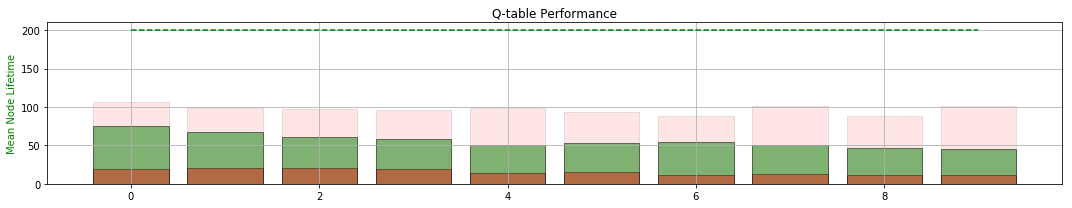

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 99.588	LOSS : 78.027	LOSS : 84.930	LOSS : 83.631	LOSS : 79.479	LOSS : 80.365	LOSS : 81.226	LOSS : 78.284	LOSS : 82.630	LOSS : 78.397	LOSS : 80.383	LOSS : 88.644	LOSS : 81.332	LOSS : 82.337	LOSS : 74.636	LOSS : 69.126	LOSS : 78.971	LOSS : 69.578	LOSS : 89.383	LOSS : 85.867	
Validating... MEAN TIME:  108.44
LOSS : 86.900	LOSS : 72.061	LOSS : 87.238	LOSS : 85.925	LOSS : 85.643	LOSS : 80.761	LOSS : 79.150	LOSS : 81.941	LOSS : 83.179	LOSS : 80.254	LOSS : 75.974	LOSS : 77.405	LOSS : 75.231	LOSS : 69.161	LOSS : 83.567	LOSS : 79.628	LOSS : 80.475	LOSS : 75.528	LOSS : 76.778	LOSS : 82.471	
Validating... MEAN TIME:  165.175
LOSS : 83.877	LOSS : 89.579	LOSS : 71.819	LOSS : 85.366	LOSS : 86.837	LOSS : 76.033	LOSS : 78.162	LOSS : 83.349	LOSS : 80.645	LOSS : 82.098	LOSS : 78.015	LOSS : 78.927	LOSS : 80.264	LOSS : 75.988	LOSS : 69.833	LOSS : 79.255	LOSS : 73.704	LOSS : 81.853	LOSS : 81.239	LOSS : 70.368	
Validat

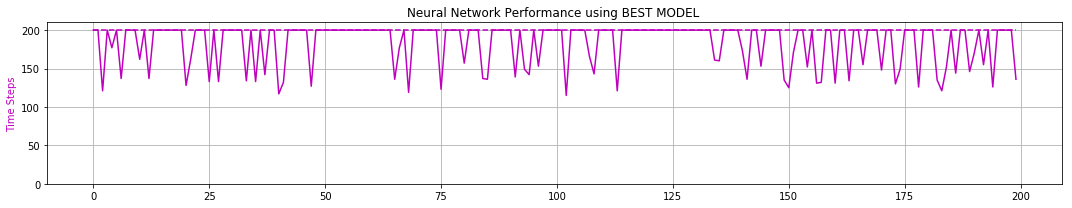

peak memory: 48999.41 MiB, increment: 43289.75 MiB
0 -max- [ 0.184  1.018  0.051  1.287  0.275]
0 -min- [-2.261 -2.888 -0.209 -1.361  0.225]

1 -max- [ 0.180  0.986  0.057  1.283  0.324]
1 -min- [-1.947 -2.605 -0.209 -1.543  0.275]

2 -max- [ 0.189  0.969  0.050  1.304  0.375]
2 -min- [-1.917 -2.586 -0.209 -1.354  0.326]

3 -max- [ 0.183  0.794  0.054  1.302  0.425]
3 -min- [-1.874 -2.518 -0.209 -1.364  0.376]

4 -max- [ 0.202  0.982  0.073  1.330  0.474]
4 -min- [-1.869 -2.411 -0.209 -1.372  0.426]

5 -max- [ 0.167  0.816  0.064  1.542  0.524]
5 -min- [-1.733 -2.387 -0.209 -1.474  0.475]

6 -max- [ 0.171  0.796  0.091  1.566  0.574]
6 -min- [-1.576 -2.387 -0.209 -1.312  0.525]

7 -max- [ 0.234  1.018  0.054  1.529  0.624]
7 -min- [-2.343 -2.962 -0.209 -1.358  0.575]

8 -max- [ 0.187  0.822  0.059  1.319  0.674]
8 -min- [-1.426 -2.281 -0.209 -1.527  0.626]

9 -max- [ 0.201  0.780  0.065  1.505  0.725]
9 -min- [-2.365 -2.964 -0.209 -1.361  0.675]

Quantization TIME:  0.4 minutes


ITERA

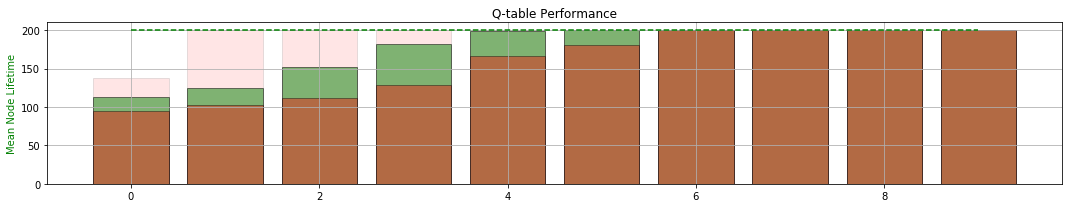

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1508.0
Total Serial Timesteps   :  1055568.0
Speed-up                 :  699.98


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   741 SUCCESS  95   8    1508    1055568     699.98
